<center> <h1>Neural Network Model</h1> </center>

## 1. Reading data

We are reading data that we already prepared. We will look at the first few columns and we will choose 78. district to work on a small subset first.  
Finally we will use one hot encoding for categorical features then split the data for train and test.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [15]:
fileName = 'C:/Users/kazIm/Desktop/projects/IE490/input/tubitak_data2_processesed2_outlier.csv'
df = pd.read_csv(fileName,  sep = ',')

In [16]:
#preview data
df.head()

,bagimsiz_bolum_kat,yuzolcumu,mevcut_alani,adil_piyasa_degeri_yasal_durum,tapunun_yasi,area,duration,mahalle_kod_4673.0,mahalle_kod_4676.0
0,1.0,875.0,125.0,115000.0,4.0,60.0,4.0,1,0
1,2.0,585.0,125.0,120000.0,3.0,60.0,13.0,1,0
2,3.0,629.0,136.0,115000.0,4.0,50.0,0.0,1,0
3,3.0,1252.0,133.0,90000.0,7.0,60.0,1.0,1,0
4,3.0,1137.0,167.0,130000.0,3.0,75.0,6.0,1,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 9 columns):
bagimsiz_bolum_kat                507 non-null float64
yuzolcumu                         507 non-null float64
mevcut_alani                      507 non-null float64
adil_piyasa_degeri_yasal_durum    507 non-null float64
tapunun_yasi                      507 non-null float64
area                              507 non-null float64
duration                          507 non-null float64
mahalle_kod_4673.0                507 non-null int64
mahalle_kod_4676.0                507 non-null int64
dtypes: float64(7), int64(2)
memory usage: 35.7 KB


In [18]:
mahalle = df["mahalle_kod"]

KeyError: 'mahalle_kod'

In [20]:
df['mahalle_kod'].describe()

In [22]:
#we can drop yasal burut alani as it has almost 1 correlation with mevcut alan
df = df.drop('yasal_burut_alani',axis=1)

In [ ]:
mahalle = df['mahalle_kod']

### One Hot Encoding for Categorical Variables

In [ ]:
# df = pd.get_dummies(df, columns=[""])
df = pd.get_dummies(df, columns=["mahalle_kod"])

In [ ]:
df.head()

In [23]:
df.shape

(507, 9)

In [24]:
# split into input (X) and output (y) variables
X = df.drop('adil_piyasa_degeri_yasal_durum',axis=1)
Y = df['adil_piyasa_degeri_yasal_durum']

In [25]:
print(X.shape)
print(Y.shape)

(507, 8)
(507,)


## 2. Develop a Baseline Neural Network Model

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


The Keras wrappers require a function as an argument. This function that we must define is responsible for creating the neural network model to be evaluated.
    
Below we define the function to create the baseline model to be evaluated. It is a simple model that has a single fully connected hidden layer with the same number of neurons as input attributes (9). The network uses rectifier activation function (relu) for the hidden layer. No activation function is used for the output layer because it is a regression problem and we want to predict numerical values directly without transform.
    
The efficient ADAM optimization algorithm is used and a mean squared error loss function is optimized. 

In [27]:
seed = 42
np.random.seed(seed)
dims = X.shape[1]
# define base model
  
def baseline_model():

    # create model
    model = Sequential()
    model.add(Dense(dims, input_shape=(dims,), init = 'normal', activation='relu'))
    model.add(Dense(9, init = 'normal', activation='relu'))
    model.add(Dense(1, init = 'normal'))
    # compile model
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer = 'adam', metrics=['mape'])
#     model.summary()
    return model


In [28]:
# Function to plot history of model learning 
def plot_history(network_history):
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.plot(network_history.history['mean_absolute_percentage_error'])
    plt.plot(network_history.history['val_mean_absolute_percentage_error'])
    plt.legend(['Training', 'Validation'])

We also initialize the random number generator with a constant random seed, a process we will repeat for each model evaluated in this tutorial. This is an attempt to ensure we compare models consistently.

In [38]:
# fix random seed for reproducibility
np.random.seed(seed)
# evaluate model 
early_stop = EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=50, verbose=0)
estimator = KerasRegressor(build_fn=baseline_model, epochs=1500, batch_size=128, verbose=0,
                          callbacks=[early_stop])

**Train and Validation Split**

In [39]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, Y, test_size=0.20, random_state=42)

In [40]:
history = estimator.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest))

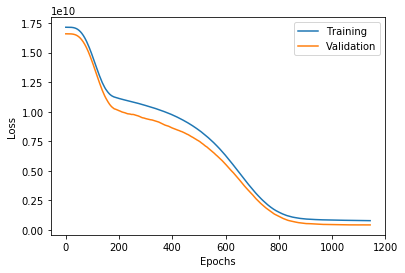

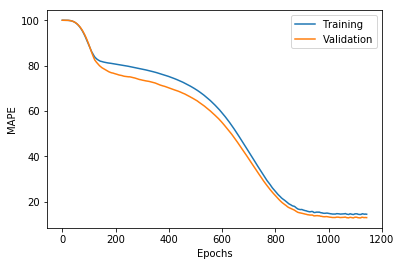

In [41]:
plot_history(history)

In [42]:
from sklearn.metrics import make_scorer

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    try:
        return np.mean(np.abs((y_true - y_pred) / np.abs(y_true)) * 100)
    except:
        return np.mean((np.abs(y_true - y_pred)+0.001 ) / (np.abs(y_true)+0.001) * 100)

def absolute_twenty_percent_error_quartile(y_true, y_pred): 
    
    pred = y_pred.reshape(-1,1) 
    actual = y_true.reshape(-1,1)
    error = np.abs(pred-actual)/np.abs(actual)
    return (error[error<=0.2].shape[0]/actual.shape[0])*100
    
mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
twentyPercentErrorQuantile = make_scorer(absolute_twenty_percent_error_quartile, greater_is_better=True)

**All sample MAPE error and 20% error quartile score**

In [43]:
mean_absolute_percentage_error(estimator.predict(X),Y)

13.144471785848882

In [44]:
absolute_twenty_percent_error_quartile(estimator.predict(X),Y)

78.89546351084813

**Out of Sample sample MAPE error and 20% error quartile score**

In [45]:
mean_absolute_percentage_error(estimator.predict(Xtest),Ytest)

12.329582992080086

In [46]:
absolute_twenty_percent_error_quartile(estimator.predict(Xtest),Ytest)

81.37254901960785

** Cross Validation**

The final step is to evaluate this baseline model. We will use 3-fold cross validation to evaluate the model.

As it is not implemented before hand, we will write our Mean Absolute Percentage Error function and 20% error quartile function to use in `cross_val_score function` of scikit-learn library. 

In [47]:
kfold = StratifiedKFold(n_splits=3, random_state=seed)
estimator2 = KerasRegressor(build_fn=baseline_model, epochs=1200, batch_size=128, verbose=0)
results = np.abs(cross_val_score(estimator2, X, Y, cv=kfold, scoring = mape))
print(results)
print()
print("Cross Validation Mean Absolute Percentage error: %.2f " % (results.mean()))

[ 14.8476281   15.54637567  69.13683218]

Cross Validation Mean Absolute Percentage error: 33.18 


In [ ]:
#  kfold = StratifiedKFold(n_splits=3, random_state=seed)
# results = np.abs(cross_val_score(estimator, X, Y, cv=kfold, scoring = twentyPercentErrorQuantile))
# print(results)
# print()
# print("Cross Validation 20 percent error quartile: %.2f " % (results.mean()))

## 3. Modeling The Standardized Dataset

An important concern with our house price dataset is that the input attributes all vary in their scales because they measure different quantities. 

It is almost always good practice to prepare our data before modeling it using a neural network model for optimization algorithms' efficiency.  

Continuing on from the above baseline model, we can re-evaluate the same model using a scaled version (0-1) of the input dataset. 

** It is important that we should not use the test data for scaling process other wise it leads to information leakage from testset**


In [58]:

# evaluate model with standardized dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_ = scaler.transform(X)
Y_ = Y/1000


In [59]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X_, Y_, test_size=0.20, random_state=42)

In [60]:
history = estimator.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest))

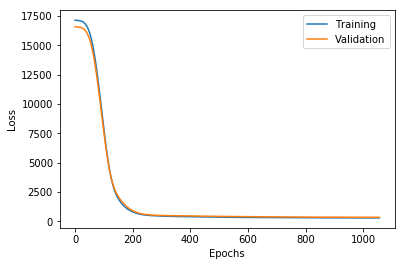

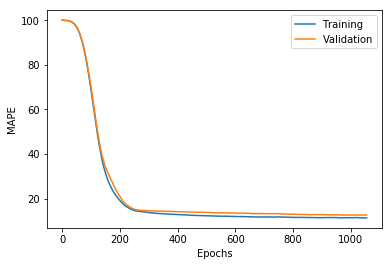

In [63]:
plot_history(history)

**All sample MAPE error and 20% error quartile score**

In [64]:
mean_absolute_percentage_error(estimator.predict(X_),Y_)

10.792265403049125

In [65]:
absolute_twenty_percent_error_quartile(estimator.predict(X_),Y_)

84.81262327416174

**Out of Sample sample MAPE error and 20% error quartile score**

In [66]:
mean_absolute_percentage_error(estimator.predict(Xtest),Ytest)

11.90445624571135

In [67]:
absolute_twenty_percent_error_quartile(estimator.predict(Xtest),Ytest)

81.37254901960785

A further extension would be to similarly apply a rescaling to the output variable such as normalizing it to the range of 0-1 and use a Sigmoid or similar activation function on the output layer to narrow output predictions to the same range.

## 4. Tune The Neural Network Topology

There are many concerns that can be optimized for a neural network model.
Perhaps the most important one is the structure of the network itself, including the number of layers and the number of neurons in each layer.  

In this section, we will evaluate two additional network topologies in an effort to further improve the performance of the model. We will look at both a deeper and a wider network topology.

### 4.1. Evaluate a Deeper Network Topology

One way to improve the performance a neural network is to add more layers. This might allow the model to extract and recombine higher order features embedded in the data.  

In this section we will evaluate the effect of adding one more hidden layer to the model. This new layer will have about half the number of neurons. Because there are heuristics that suggest that number of neurons in the next layer should not exceed the half of the previuos layer's number of neurons.

In [68]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(dims, input_shape=(dims,), init = 'normal', activation='relu'))
    model.add(Dense(9, init = 'normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, init = 'normal'))
    # compile model
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer = 'adam', metrics=['mape'])
#     model.summary()
    return model

We will follow the same methodology as above;

In [76]:
# fix random seed for reproducibility
np.random.seed(seed)
# evaluate model 
estimator = KerasRegressor(build_fn=larger_model, epochs=1500, batch_size=128, verbose=0,
                          callbacks=[early_stop])

In [77]:
history = estimator.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest))

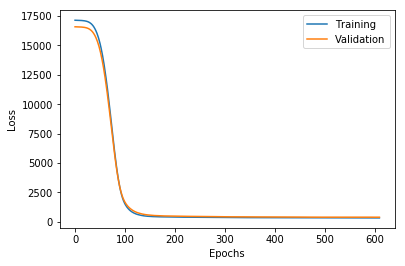

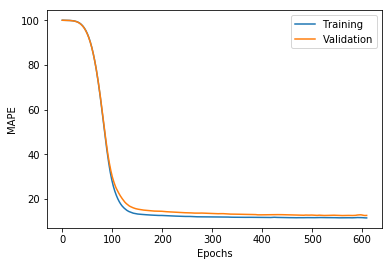

In [78]:
plot_history(history)

**Out of Sample sample MAPE error and 20% error quartile score**

In [81]:
mean_absolute_percentage_error(estimator.predict(Xtest),Ytest)

11.801592746062688

In [82]:
absolute_twenty_percent_error_quartile(estimator.predict(Xtest),Ytest)

84.31372549019608

### 4.2. Evaluate a Wider Network Topology

Another approach to increasing the representational capability of the model is to create a wider network.  
In this section we evaluate the effect of keeping a shallow network architecture and nearly doubling the number of neurons in the one hidden layer.  
Here, we have increased the number of neurons in the hidden layer compared to the baseline model from 9 to 15.

In [83]:
# define wider model
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(dims, input_shape=(dims,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # compile model
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer = 'adam', metrics=['mape'])
#     model.summary()
    return model

We will follow the same methodology as above;

In [84]:
# fix random seed for reproducibility
np.random.seed(seed)
# evaluate model 
estimator = KerasRegressor(build_fn=wider_model, epochs=1500, batch_size=128, verbose=0,
                          callbacks=[early_stop])

In [85]:
history = estimator.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest))

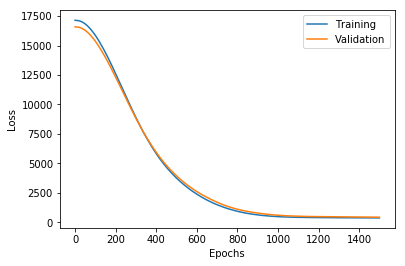

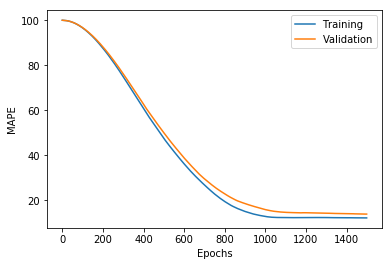

In [86]:
plot_history(history)

**Out of Sample sample MAPE error and 20% error quartile score**

In [87]:
mean_absolute_percentage_error(estimator.predict(Xtest),Ytest)

12.794222246792936

In [88]:
absolute_twenty_percent_error_quartile(estimator.predict(Xtest),Ytest)

78.43137254901961

** We saw that deeper model is the best of the three.**

We may want to add another layer

In [99]:
# define the model
def larger_model2():
    # create model
    model = Sequential()
    model.add(Dense(dims, input_shape=(dims,), init = 'normal', activation='relu'))
    model.add(Dense(10, init = 'normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, init = 'normal'))
    # compile model
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer = 'adam', metrics=['mape'])
#     model.summary()
    return model

We will follow the same methodology as above;

In [105]:
# fix random seed for reproducibility
np.random.seed(seed)
# evaluate model 
early_stop = EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=100, verbose=0)
estimator = KerasRegressor(build_fn=larger_model2, epochs=1500, batch_size=128, verbose=0,
                          callbacks=[early_stop])

In [106]:
history = estimator.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest))

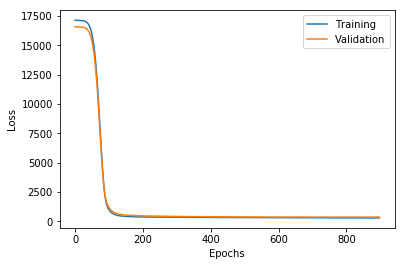

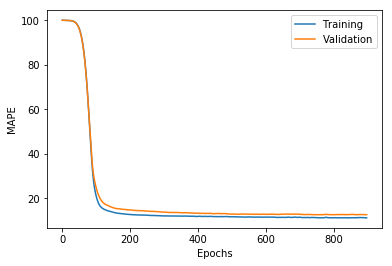

In [107]:
plot_history(history)

**Out of Sample sample MAPE error and 20% error quartile score**

In [108]:
mean_absolute_percentage_error(estimator.predict(Xtest),Ytest)

11.883877360329253

In [109]:
absolute_twenty_percent_error_quartile(estimator.predict(Xtest),Ytest)

83.33333333333334

** That did not improve our model ** 